In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.metrics import accuracy_score

sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, 
                        n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0., )
]

### 1. Решающие деревья. Визуализация. 

### EX. 1

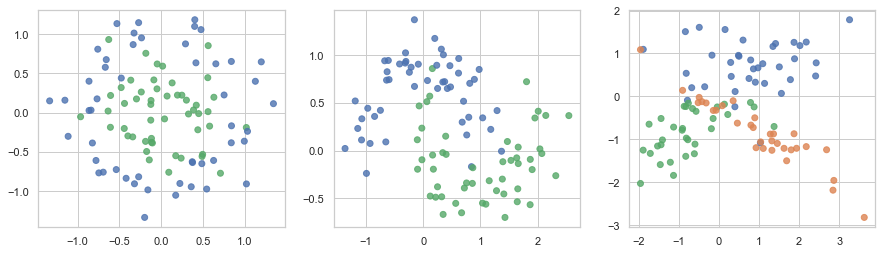

In [66]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

In [70]:
def plot_surface(clf, X, y, ax):
    plt.sca(ax)
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

[1.0, 1.0, 1.0]
[0.56, 0.8533, 0.7733]


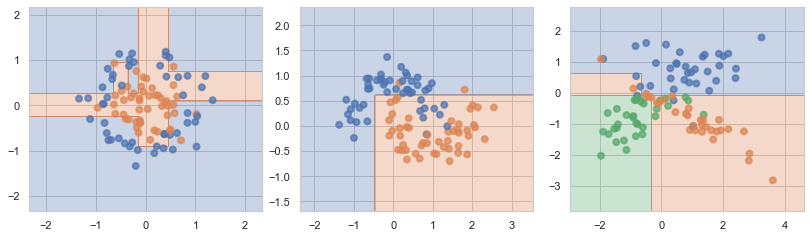

In [77]:
accuracy_train = list()
accuracy_test = list()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i, (x, y) in enumerate(datasets):
    C_train, C_test, T_train, T_test = train_test_split(x, y, test_size=0.75, random_state=13)
    tree = DecisionTreeClassifier(random_state=13)
    tree.fit(C_train, T_train)
    t_train_predict = tree.predict(C_train)
    t_test_predict = tree.predict(C_test)
    accuracy_train.append(round(accuracy_score(T_train, t_train_predict), 4)) 
    accuracy_test.append(round(accuracy_score(T_test, t_test_predict), 4)) 
    plot_surface(tree, x, y, axs[i])
    cur_ax_idx += 1
    
print(accuracy_train)
print(accuracy_test)

### Ex. 2

In [113]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid = (
    {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None],
        'max_features': ['auto', 'log2', None], 
        'min_samples_leaf': range(1, 10), 
        'min_samples_split': range(2, 10),
        'criterion': ['gini', 'entropy']
    }
         )
estimator = DecisionTreeClassifier(random_state = 13)

In [131]:
max_depth = [3, 5, 7, 9, 10, None]
min_samples_leaf = range(1, 10)

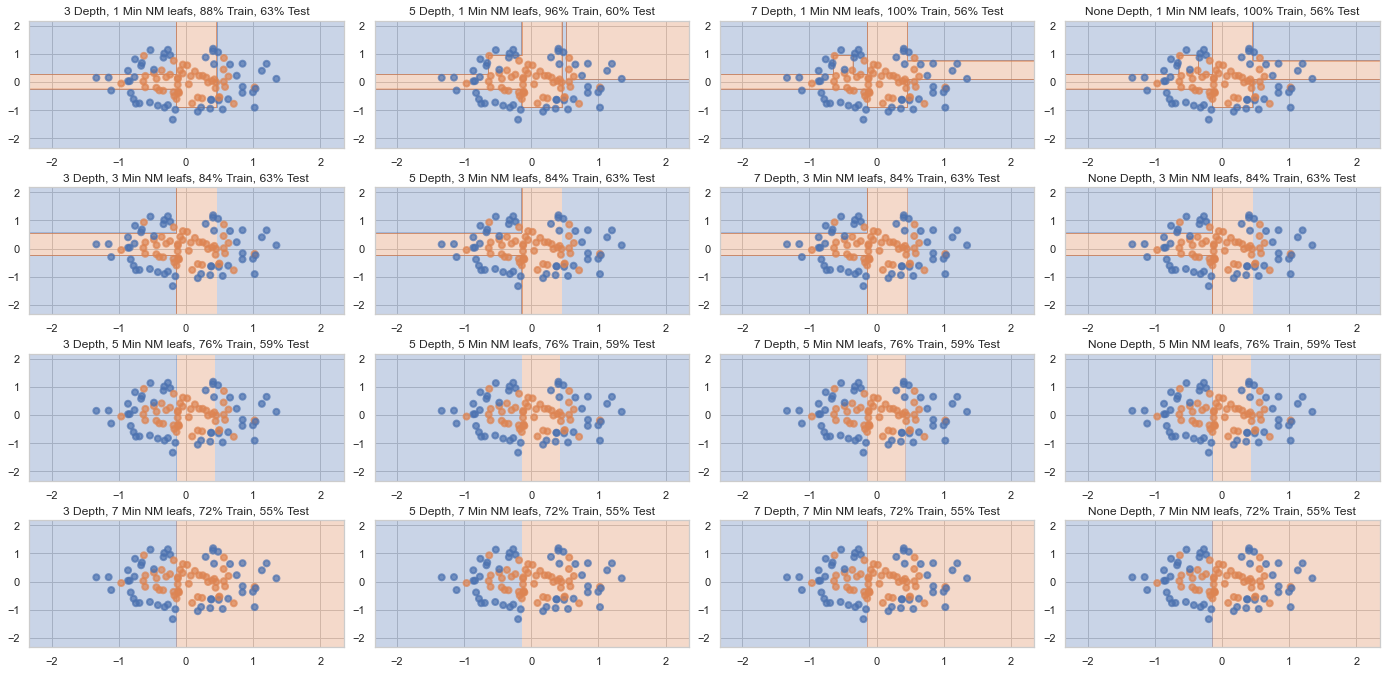

In [110]:
min_samples_leaf = [1, 3, 5, 7]
max_depth = [3, 5, 7, None]

dataset = datasets[0]
fig, ax = plt.subplots(4, 4, figsize=(20, 10))
i = 0
j = 0

for d in min_samples_leaf:
    for l in max_depth:
        tree = DecisionTreeClassifier(max_depth=l, 
                                      min_samples_leaf=d, 
                                      random_state=13)
        C_train, C_test, T_train, T_test = train_test_split(dataset[0], dataset[1], 
                                                            test_size=0.75, random_state=13)
        tree.fit(C_train, T_train)
        t_train_predict = tree.predict(C_train)
        t_test_predict = tree.predict(C_test)
        accuracy_train = round(accuracy_score(T_train, t_train_predict)* 100)
        accuracy_test = round(accuracy_score(T_test, t_test_predict)* 100)
        plot_surface(tree, dataset[0], dataset[1], ax[j, i])
        plt.title('{} Depth, {} Min NM leafs, {}% Train, {}% Test'.format(l, d, accuracy_train, accuracy_test))

        i+= 1
    j+= 1
    i=0

#### На тестовой выборке лучшие результаты показывают деревья со средней глубиной и либо малым, либо средним минимальным количеством листьев в вершине (до 5). 
#### Хотя бы одна из характеристик должна быть ограничена для лучших обобщающих возможностей алгоритма, иначе происходит переобучение - примеры с глубиной 5 и 1 листом, неограниченной глубиной и 1 листом, и неограниченной глубиной и 5-7 листьями в вершине.
Деревья быстро переобучаются при увеличении глубины дерева и ограничения на 1 лист в вершине.
Также наиболее плохой обобщающей способностью обладают деревья с большим количеством листов в вершине - от 5-7. У них нет возможности обучиться при условии выполнения условия на количество листов, разделяющая поверхность таких деревьев довольно простая.

### 2. Решающие деревья своими руками 

### EX. 3 

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков

In [111]:
import numpy as np
from collections import Counter

In [ ]:
def find_best_split(feature_vector, target_vector):
    """
    Под критерием Джини здесь подразумевается следующая функция:
    $$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$,
    $R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
     $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)
    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

    pass

In [ ]:
class DecisionTree:
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(self, sub_X, sub_y, node):
        if np.all(sub_y != sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0] 
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(1, sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])
                clicks = Counter(sub_X[sub_y == 1, feature])
                ratio = {}
                for key, current_count in counts.items():
                    if key in clicks:
                        current_click = clicks[key]
                    else:
                        current_click = 0
                    ratio[key] = current_count / current_click
                sorted_categories = list(map(lambda x: x[1], sorted(ratio.items(), key=lambda x: x[1])))
                categories_map = dict(zip(sorted_categories, list(range(len(sorted_categories)))))

                feature_vector = np.array(map(lambda x: categories_map[x], sub_X[:, feature]))
            else:
                raise ValueError

            if len(feature_vector) == 3:
                continue

            _, _, threshold, gini = find_best_split(feature_vector, sub_y)
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                split = feature_vector < threshold

                if feature_type == "real":
                    threshold_best = threshold
                elif feature_type == "Categorical":
                    threshold_best = list(map(lambda x: x[0],
                                              filter(lambda x: x[1] < threshold, categories_map.items())))
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
        else:
            raise ValueError
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[split], node["right_child"])

    def _predict_node(self, x, node):
        # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        pass

    def fit(self, X, y):
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

In [135]:
st_df = pd.read_csv('data/students.csv')
st_df.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


In [124]:
target = st_df['UNS']

In [134]:
df = st_df.drop('UNS', axis=1)